# Gathering EXFOR data
In this tutorial we will walk through the parsing and querying of EXFOR for angular distributions (e.g. differential cross sections and analyzing powers), with special attention paid to handling edge cases in how the data is represented, and curating a data set from multiple experiments, accounting for outliers.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from exfor_tools import (
    AngularDistribution,
    ExforEntryAngularDistribution,
    categorize_measurements_by_energy,
    filter_out_lab_angle,
    init_exfor_db,
    plot_angular_distributions,
    query_for_entries,
)

Using database version x4i3_X4-2023-04-29 located in: /home/beyerk/mambaforge/envs/sage/lib/python3.11/site-packages/x4i3/data


## Demonstration of data retrieval and plotting for various reactions and quantities

First let's try to read in $(p,p)$ data from entry C0624:

In [3]:
ca48_pp = ExforEntryAngularDistribution(
    entry="C0624",
    target=(48, 20),
    projectile=(1, 1),
    quantity="dXS/dA",
    vocal=True,
)

Failed to parse subentry C0624005:
Subentry C0624005 has an ambiguous set of error labels:
ERR-SYS
ERR-7
ERR-9
DATA-ERR



In [4]:
ca48_pp.measurements

[]

In [5]:
ca48_pp.failed_parses

{'C0624': ('C0624005',
  NotImplementedError('Subentry C0624005 has an ambiguous set of error labels:\nERR-SYS\nERR-7\nERR-9\nDATA-ERR\n'))}

## It failed. What gives? 

We failed to parse anything from this entry. Notice the error message provided by `exfor_tools`: ambiguous error labels. Let's take a look at the ERR-ANALYSIS section of [that entry](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=123390&&sub=C0624&plus=1) and see if we can make sense of these column labels:


> ERR-ANALYS (DATA-ERR) Relative uncertainty.  
          (ERR-S,,1.) Statistical uncertainty <1%.  
           Systematic uncertainties:  
           (ERR-1,,1.) Dead time correction                 <1.0%  
           (ERR-2,,0.1)  Correction for reaction losses  
                                                 in NaI(Tl) <0.1%  
           (ERR-3,,0.3)  Finite geometry correction         <0.3%  
           (ERR-4,,1.)  Detector angle                      <1.0%  
           (ERR-5,,1.5)  Incident proton energy             <1.5%  
           (ERR-6,,2.)  Impurity subtraction - worst case    2.0%  
           (ERR-SYS) Uncertainty in the absolute scale includes:  
           (ERR-7) Uncertainty in the detector solid angle  
           (ERR-8,,1.) Uncertainty in the target rotation angle  
           (ERR-9) Uncertainty in the beam current integration  
            * Uncertainty in the target thickness  

Ok, it looks like `DATA-ERR` does not include systematic uncertainties in the normalization, or absolute scale (e.g. it includes ERR-1 through 6, but not 7 though 9 which are lumped under `ERR-SYS`). What we can do is parse this measurement, explicitly treating `DATA-ERR` and `ERR-SYS` as two independent sources of uncertainty:

In [6]:
ca48_pp = ExforEntryAngularDistribution(
    entry="C0624",
    target=(48, 20),
    projectile=(1, 1),
    quantity="dXS/dA",
    vocal=True,
    parsing_kwargs={
        "err_labels": ["DATA-ERR", "ERR-SYS"],
        "err_treatment": "independent",
    },
)

Found subentry C0624005 with the following columns:
['EN-ERR', 'ERR-SYS', 'ERR-7', 'ERR-9', 'EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']


Look at that, worked like a charm! Let's grab some neutron measurements too.=:

In [7]:
ca48_nn = ExforEntryAngularDistribution(
    entry="14303",
    target=(48, 20),
    projectile=(1, 0),
    quantity="dXS/dA",
    vocal=True,
)

Found subentry 14303004 with the following columns:
['EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry 14303005 with the following columns:
['EN', 'EN-ERR', 'ANG-CM', 'DATA-CM', 'DATA-ERR']


Now let's plot all this data:

In [8]:
label_settings = {
    "label_xloc_deg": None,
    "label_offset_factor": 0.1,
    "label_energy_err": False,
    "label_offset": True,
    "label_incident_energy": True,
    "label_excitation_energy": False,
    "label_exfor": False,
}

(0.0001, 1000000000.0)

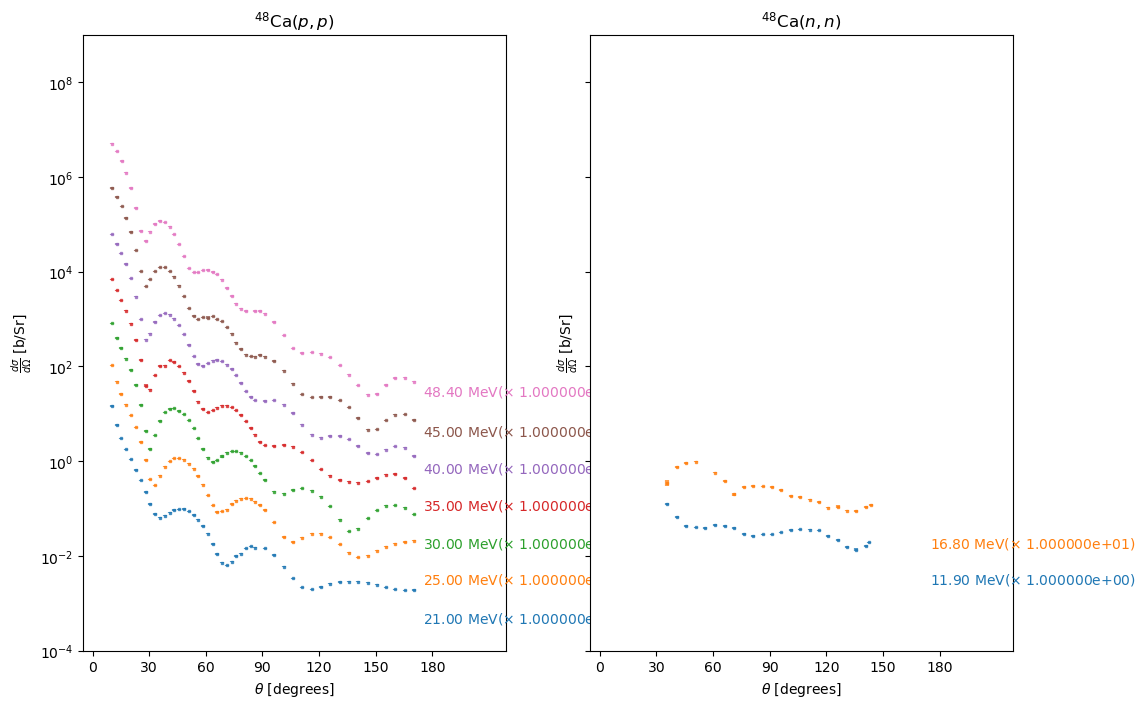

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
ca48_pp.plot(
    ax1,
    offsets=10,
    label_kwargs=label_settings,
)
ca48_nn.plot(
    ax2,
    offsets=10,
    label_kwargs=label_settings,
)
ax1.set_xlim([-5, 219])
ax2.set_xlim([-5, 219])
ax1.set_ylim([1e-4, 1e9])

### That's pretty, but I can't really see the uncertainties? What gives?

They're there. Let's zoom in our y axis a bit:

(0.001, 10)

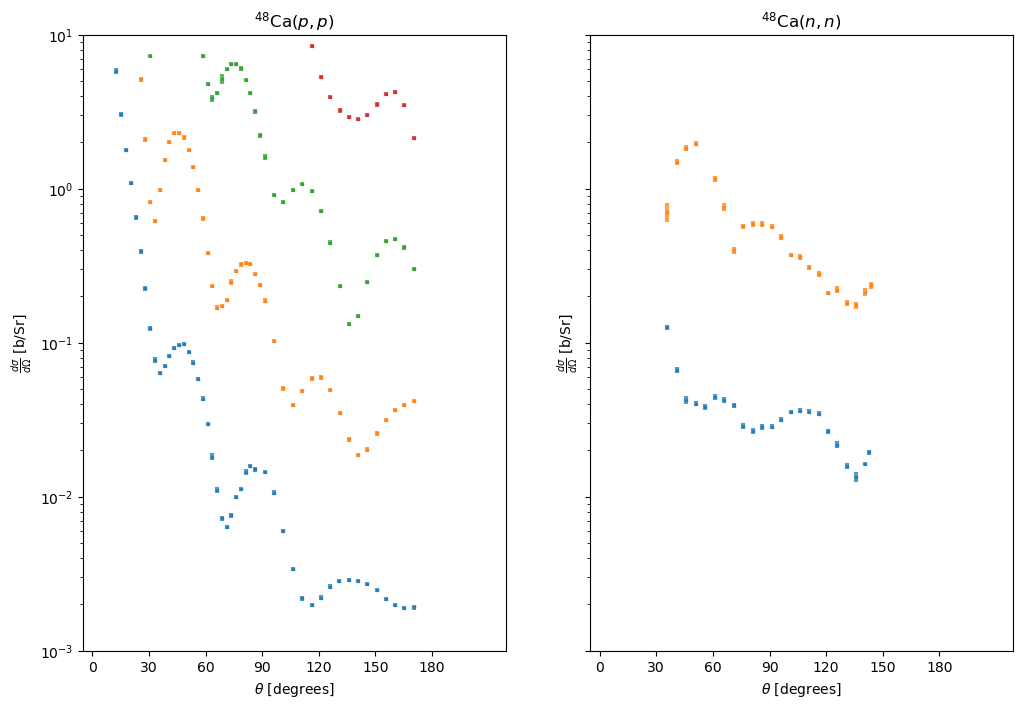

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
ca48_pp.plot(
    ax1,
    offsets=20,
    label_kwargs=None,
)
ca48_nn.plot(
    ax2,
    offsets=20,
    label_kwargs=None,
)
ax1.set_xlim([-5, 219])
ax2.set_xlim([-5, 219])
ax1.set_ylim([1e-3, 10])

## Nice, let's look at some other data types.

In [11]:
ca48_pp_ana = ExforEntryAngularDistribution(
    entry="O0239",
    target=(48, 20),
    projectile=(1, 1),
    quantity="Ay",
    vocal=True,
)

Found subentry O0239015 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']
Found subentry O0239017 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']
Found subentry O0239019 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA']


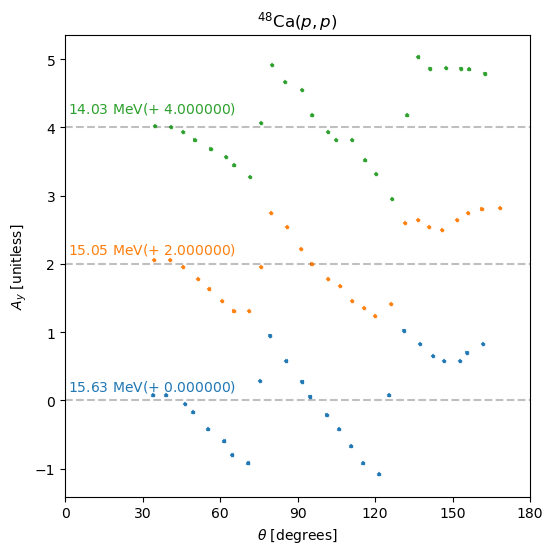

In [12]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

ca48_pp_ana.plot(
    ax,
    offsets=2,
    log=False,
    draw_baseline=True,
    label_kwargs={
        "label_xloc_deg": None,
        "label_offset_factor": 0.1,
        "label_energy_err": False,
        "label_offset": True,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": False,
    },
)

In [13]:
ca48_pp_ruth = ExforEntryAngularDistribution(
    entry="O0239",
    target=(48, 20),
    projectile=(1, 1),
    quantity="dXS/dRuth",
    vocal=True,
)

Found subentry O0239014 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']
Found subentry O0239016 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']
Found subentry O0239018 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']


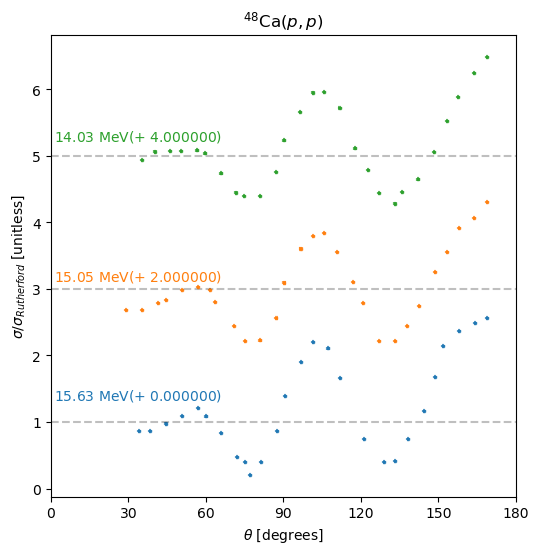

In [14]:
fig, (ax) = plt.subplots(1, 1, figsize=(6, 6), sharey=True)

ca48_pp_ruth.plot(
    ax,
    offsets=2,
    log=False,
    draw_baseline=True,
    baseline_offset=1,
    label_kwargs={
        "label_xloc_deg": 1,
        "label_offset_factor": 0.1,
        "label_energy_err": False,
        "label_offset": True,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": False,
    },
)

## Querying for multiple entries
Let's figure out how to query EXFOR for multiple entries and plot them all

In [15]:
entries, failed_parses = query_for_entries(
    target=(208, 82),
    projectile=(1, 1),
    quantity="dXS/dA",
    Einc_range=[10, 100],
    vocal=True,
    filter_subentries=filter_out_lab_angle,
)
print(f"\nFound {len(entries.keys())} entries")
print(f"\nFailed to parse {len(failed_parses.keys())} entries")

Found subentry C0893042 with the following columns:
['EN', 'ANG-CM', 'DATA-CM', 'ERR-S']
Found subentry C1019034 with the following columns:
['ERR-S', 'EN', 'ANG-CM', 'DATA-CM']
Found subentry E1201014 with the following columns:
['EN', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry E1846023 with the following columns:
['EN-RSL', 'E-RSL', 'E-LVL-ERR', 'EN', 'ANG-CM', 'DATA-CM']
Found subentry O0032025 with the following columns:
['EN', 'ANG-CM', 'DATA', 'ERR-S']
Failed to parse subentry O0142011:
Subentry O0142011 has an ambiguous set of error labels:
ERR-1
ERR-T

Found subentry O0157004 with the following columns:
['EN', 'ANG-ERR', 'DATA-ERR', 'ANG-CM', 'DATA-CM']
Found subentry O0166023 with the following columns:
['EN', 'ANG-ERR-D', 'ERR-DIG', 'ANG-CM', 'DATA']
Found subentry O0208009 with the following columns:
['EN', 'EN-RSL-FW', 'EN-RSL', 'ANG-CM', 'DATA-CM', 'DATA-ERR']
Found subentry O0211017 with the following columns:
['EN', 'EN-RSL', 'ANG-CM', 'DATA', 'ERR-T']
Found subentr

### Let's handle these failed parses by manually adding them to `entries`
This will require going and reading the `ERR-ANALYSIS` part of the common section of each entry.

In [16]:
for k, v in failed_parses.items():
    print(f"Entry: {k}")
    print(v.failed_parses[k][1])

Entry: O0142
Subentry O0142011 has an ambiguous set of error labels:
ERR-1
ERR-T

Entry: O0391
Subentry O0391008 has an ambiguous set of error labels:
ERR-1
ERR-2
ERR-3
ERR-4
ERR-T

Entry: T0101
Subentry T0101004 has an ambiguous set of error labels:
DATA-ERR1
DATA-ERR



In [17]:
entries["O0142"] = ExforEntryAngularDistribution(
    entry="O0142",
    target=(208, 82),
    projectile=(1, 1),
    quantity="dXS/dA",
    Einc_range=[10, 100],
    vocal=True,
    parsing_kwargs={
        "err_labels": ["ERR-1", "ERR-T"],
        "err_treatment": "independent",
    },
)

entries["O0391"] = ExforEntryAngularDistribution(
    entry="O0391",
    target=(208, 82),
    projectile=(1, 1),
    quantity="dXS/dA",
    Einc_range=[10, 100],
    vocal=True,
    parsing_kwargs={
        "err_labels": ["ERR-T"],
        "err_treatment": "independent",
    },
)

entries["T0101"] = ExforEntryAngularDistribution(
    entry="T0101",
    target=(208, 82),
    projectile=(1, 1),
    Einc_range=[10, 100],
    quantity="dXS/dA",
    vocal=True,
    parsing_kwargs={
        "err_labels": ["DATA-ERR", "DATA-ERR1"],
        "err_treatment": "independent",
    },
)

Found subentry O0142011 with the following columns:
['EN', 'ERR-1', 'ANG-CM', 'DATA-CM', 'ERR-T']
Found subentry O0391008 with the following columns:
['EN', 'EN-ERR', 'EN-RSL', 'ERR-1', 'ERR-2', 'ERR-3', 'ERR-4', 'ANG-CM', 'DATA', 'ERR-T']
Found subentry T0101004 with the following columns:
['DATA-ERR1', 'EN', 'ANG-CM', 'DATA-CM', 'DATA-ERR']


# That was easy!
Now, let's plot measurements from all of those entries on the same figure

In [18]:
measurements_categorized = categorize_measurements_by_energy(entries)

(-5.0, 280.0)

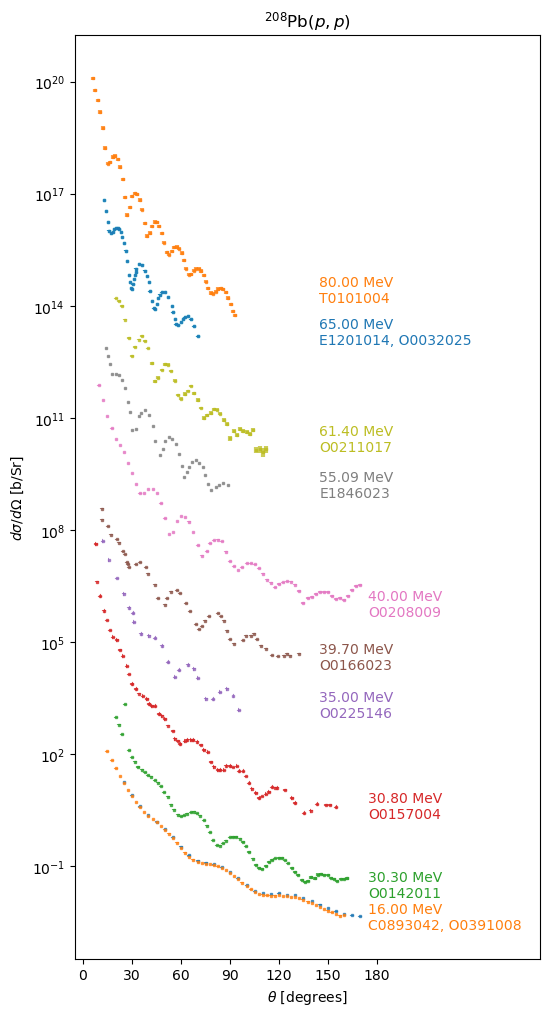

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
plot_angular_distributions(
    measurements_categorized,
    ax,
    offsets=100,
    data_symbol=r"$d\sigma/d\Omega$",
    rxn_label=list(entries.values())[0].rxn,
    label_kwargs={
        "label_xloc_deg": None,
        "label_offset_factor": 0.1,
        "label_energy_err": False,
        "label_offset": False,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": True,
    },
)
ax.set_xlim([-5, 280])

## Some things to notice:
- EXFOR subentries E1201014 and O0032025 are duplicates
- EXFOR subentry [O0142011](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=123189&&sub=O0142&plus=1) has an outlier (the 4th point). Looking at the data, it is exactly 10 times what it would be expected. It is likely this is the result of transcription error.

Let's fix these and plot again,

In [20]:
del entries["E1201"]

In [21]:
print(entries["O0142"].measurements[0].y[:10])

[ 9.539   6.037   3.374  21.561   1.264   0.8222  0.6223  0.4491  0.3806
  0.3291]


In [22]:
entries["O0142"].measurements[0].y[3] *= 0.1
entries["O0142"].measurements[0].y_err[3] *= 0.1

This seems like a good time to explain the argument `Einc_tol`. This parameter is an energy in MeV. If two data sets at two incident energies are within `Einc_tol` of eachother, `categorize_measurements_by_energy` treats them as part of the same category.

In [23]:
measurements_categorized = categorize_measurements_by_energy(entries, Einc_tol=0.1)

In [24]:
[[m.Einc for m in l] for l in measurements_categorized]

[[16.0, 16.0],
 [30.3],
 [30.8],
 [35.0],
 [39.7],
 [40.0],
 [55.09],
 [61.4],
 [65.0],
 [80.0]]

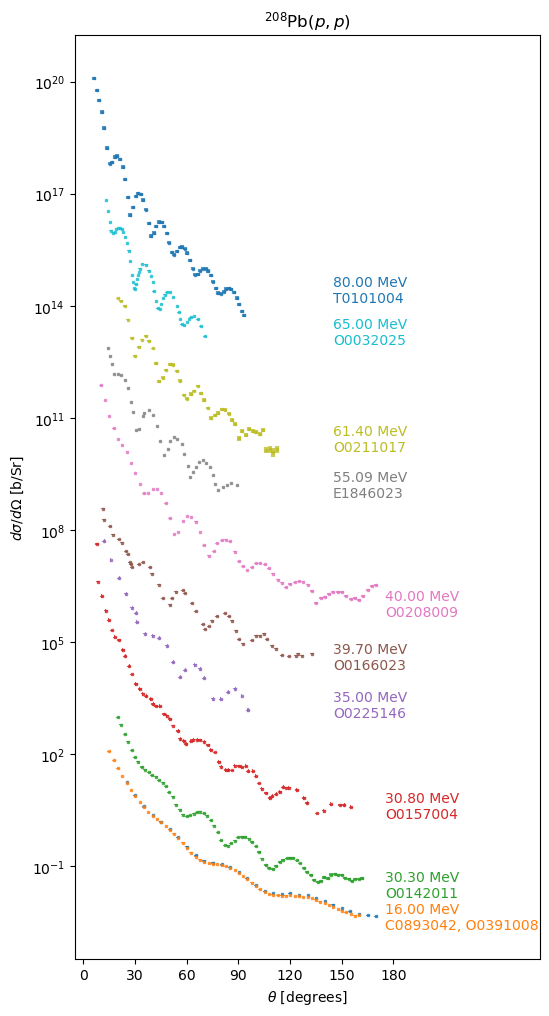

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
plot_angular_distributions(
    measurements_categorized,
    ax,
    offsets=100,
    data_symbol=r"$d\sigma/d\Omega$",
    rxn_label=list(entries.values())[0].rxn,
    label_kwargs={
        "label_xloc_deg": None,
        "label_offset_factor": 0.1,
        "label_energy_err": False,
        "label_offset": False,
        "label_incident_energy": True,
        "label_excitation_energy": False,
        "label_exfor": True,
    },
)
ax.set_xlim([-5, 265])

plt.savefig("lead_208_pp_dxds.png")